### Project 3

#### Executive Summary
- To use a combination of Natural Language Processing and Classfication modelling, to find out the Topics, given wall of text in each posts
- This could be extended to be able to classifiy if a wall of text belongs to which language (e.g. English, Spanish, French)



In [1]:
#!pip install wordcloud

In [2]:
# Import
import numpy as np
import pandas as pd
import seaborn as sns
import os
import warnings
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction import stop_words
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
warnings.warn("once")
sns.set()


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: once


In [3]:
# Set display width and columns
pd.set_option('display.width', 5000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 500)

In [4]:
# To monitor time to run codes
start_time = time.time()

In [5]:
# Set location of files
os.chdir(r'E:\GA_DSI\Classes_clone\projects1234\project_3\datasets')

In [6]:
# Loading in dataset after scrapping from reddit
tifu_csv = 'url_1.csv'
fps_csv = "url_4.csv"

In [7]:
# import csv and read it as pandas DF
with open(tifu_csv, mode="r", encoding="utf8") as tifu_raw:
    tifu_raw = pd.read_csv(tifu_raw)

with open(fps_csv, mode="r", encoding="utf8") as fps_csv:
    fps_csv = pd.read_csv(fps_csv)

In [8]:
# Selecting needed features from reddit posts
features_needed = ['subreddit', 'selftext', 'title']

tifu_features = tifu_raw[features_needed]
fps_features = fps_csv[features_needed]

In [9]:
# Function to find null values 
def check_null_counts(df):
    null_counts = df.isnull().sum()
    print(null_counts[null_counts > 0])

In [10]:
check_null_counts(tifu_features)
# No null values for tifu subreddit

Series([], dtype: int64)


In [11]:
check_null_counts(fps_features)
# 37 null values present in tifu subreddit
# need to check how best to fillna into null values

selftext    37
dtype: int64


In [12]:
# Blanks on selftext to be filled in with title due to title being the next best substitude
fps_features['selftext'].fillna(fps_features['title'], inplace=True)

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [13]:
check_null_counts(fps_features)
# No null values for tifu subreddit after fillna

Series([], dtype: int64)


In [14]:
# Drop duplicates from 'selftext' feature
tifu_features.drop_duplicates(subset='selftext', inplace=True)
fps_features.drop_duplicates(subset='selftext', inplace=True)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# Create a combine csv, an append of train and test set to clean
combine_raw = tifu_features.append(fps_features, ignore_index=True, sort=False).copy()
combine_raw.to_csv('combine_raw.csv', index=None, header=True) # creating a new combined file
combine_raw.drop(['title'], axis=1, inplace=True)

In [16]:
# Regex to clean df
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.replace(r"\(https?:\/\/.*[\r\n]*", "")
    df[text_field] = df[text_field].str.replace(r"[^\w\s]", "")
    return df

In [17]:
combine_clean = standardize_text(combine_raw, 'selftext')

In [18]:
# Part of cleaning process
# Instantiate Tokenizer
# Can use other Tokenizer other than RegexpTokenizer
# tokeniszer is an instance of the Reg.. class
tokenizer = RegexpTokenizer(r'\w+')
combine_clean["tokens"] = combine_clean["selftext"].apply(tokenizer.tokenize)

combine_clean.drop(['selftext'], axis=1, inplace=True)

In [19]:
# Lemmatization
wnl = WordNetLemmatizer()

def lemmatize(tokenized_text_list):
    text = [wnl.lemmatize(word) for word in tokenized_text_list]
    return text

combine_clean['lemmatized'] = combine_clean['tokens'].apply(lambda x: lemmatize(x))


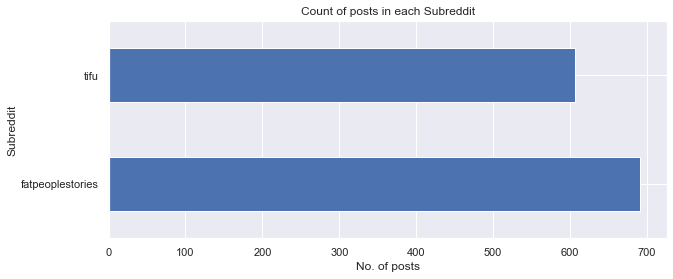

In [50]:
# Bar plot to show class balance
plt.figure(figsize=(10, 4))
combine_clean['subreddit'].value_counts().plot(kind='barh')
plt.title("Count of posts in each Subreddit")
plt.ylabel("Subreddit")
plt.xlabel("No. of posts")
plt.show()
# notice on the imbalance class

In [23]:
# converting stopwords to set
stop_words = stopwords.words('english')
# Updating new stop_words after EDA in wordcloud to discover common words across "tifu" and "fatpeoplestories"
new_stops = ['one', 'im', 'time', 'got']
stop_words.extend(new_stops)
stop_words = set(stop_words)
stop_words = list(stop_words)

In [24]:
# removing stop words
# use .apply for cycling thru each column
gd_lem_words = [w for w in combine_clean['lemmatized'] if w not in stop_words]
combine_clean['gd_lem_words'] = combine_clean['tokens'].apply(lambda x: [item for item in x if item not in stop_words])

# .join to combine tokenized words back into a string, as in input into countvect pipeline
combine_clean['gd_lem_words'] = combine_clean['gd_lem_words'].apply(lambda x: " ".join(x))

# drop not need features
combine_clean.drop(['lemmatized', 'tokens'], axis=1, inplace=True)

In [25]:
#combine_clean[combine_clean['subreddit'] == "tifu"]["gd_lem_words"]

0      fuck well support darn thing greatly enjoy reading stories posted subreddits like rtifu like less reading computer old new reddit put much clutter around text formatting always feels less ideal long pieces text ago realization fix promptly set started bit custom css realized could better scripting sort spiraled control knew made full blown browser extension extension tldr adds beautiful clean reading mode reddit posts comments extension takes text posts comments transforms text thisor dark t...
1                                                                                                                                   hey everyone voting thread fuck month april choose favorite post top 5 threads vote heresee next month rtifu mod team tifu spending last year reddit talking mutedtifu trying send friend screenshot subreddit sent tits pentagram harness insteadtifu thinking divorce april fools gagtifu submitting hardcore furry erotica instead final papertifu matching homophobic

In [26]:
#combine_clean[combine_clean['subreddit'] == "fatpeoplestories"]

,subreddit,gd_lem_words
607,fatpeoplestories,hey gumdrops updates issues thanks excuse whilst crawl upon soapbox starters ive seen lot mobile cant see rules well 1 posts subject mod review removal 2 fatpeoplehate fatpeopleobservations storywithafatpersoninit 3 direct linking parts reddit blogs social network accounts 4 personal pictures information unless ask pictures personal information 5 hyperbole expected sub place practice creative writing skills expect situations grounded reality similarly happened posts removed 6 harass authors ...
608,fatpeoplestories,greetings fellow enjoyers beetus stories post thoughts subreddit comments general questions general discussions whatever like post catch silly questions may wanting answer small things never thought worth post may days filled lots food fatlogic
609,fatpeoplestories,linkampx200b first thank everyone kind words support personal stories want address things mainly wrote still much angry fathers passing mods please remove allowed ampx200b 1 getting shape kidssofamily want anyone else sure family great motivator need want get better wont make permanent meaningful progress unless ran gambit alcohol came back deployment last making self improvements others futile ampx200b 2 slow suicide people dont understand obesity way understand alcoholism drug abuse abusin...
610,fatpeoplestories,stories boss really sums lets call coughing ham boss chb shes barely 5 weighs least 200 lbs maybe 250 lbs carries majority weight biggo booty tree trunk thighs 50 yrs old fair cancer survivor straight boss years ago according shes steadily putting weight long 10 15 years first quick background chb disgusting health hazard habit coughing sneezing without covering mouth turning head walk way hall go community kitchen food cough whole like oh cough looks good cough cough gonna get cough piece n...
611,fatpeoplestories,work office building open floor plan half customer service agents half assorted departments manager charge department manager others managers pretty much given free reign choose run department different departments different rules owners dont micromanage key difference dont want employees eating desks customer service manager doesnt care predictably customer service reps easily weigh 50100 lbs anyone else office minihams every day see full meals chinese food pancakes pizza like also departme...
612,fatpeoplestories,maybe 185lbs 56 went vegan 6 months ago went full whole foods weeks ago far 20 pounds 45 go dont emoham based mybodygallery easily 300 350lbs 56 horrible person horrible worker worked emoham twice store transfer another store heard things professional tried best nice include conversation even spread rumors manager fired whole story tell later hadnt done many ham things except kept calling fat around pausing assuming expected reply youre curvy something along lines gave nasty looks ignored la...
613,fatpeoplestories,starting year company began implementing month long event called wellness month basically every twothree days fitness sessions bike rides soccer ab sessions etc employees promote better health exercise habits good way get office move around considering sitting 8 hours day events arent necessarily mandatory highly recommended attend showing bad look corporate environment thats people notice judge thing manager notorious workaholic works long hours rarely uses paid benefits company grants accu...
614,fatpeoplestories,crazy story drives nuts fat half size people question dont capability cause problems work restaurant aisles tables bar well walkway kitchen pretty narrow manager although sweet gigantic prob around 55 300 lbs stand front place food gets picked servers impossible get get silverwareplateswhatever rude along fat customers stand bar block way know customer always right fuck already extremely self conscious size would never anything body would cause someone else problems always terrified bus tabl...
615,fatpeoplestories,friend way pick gf couple days ago encount

In [27]:
wordcloud_text_tifu = " ".join(combine_clean[combine_clean['subreddit'] == "tifu"]["gd_lem_words"])
wordcloud_text_fps = " ".join(combine_clean[combine_clean['subreddit'] == "fatpeoplestories"]["gd_lem_words"])

In [28]:
wordcloud_tifu = WordCloud(background_color="white").generate(wordcloud_text_tifu)
wordcloud_fps = WordCloud(background_color="white").generate(wordcloud_text_fps)

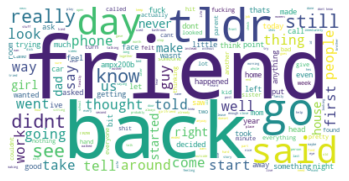

In [29]:
# Display the generated image:
plt.imshow(wordcloud_tifu, interpolation='bilinear')
plt.axis("off")
plt.show()

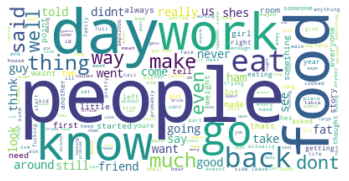

In [30]:
# Display the generated image:
plt.imshow(wordcloud_fps, interpolation='bilinear')
plt.axis("off")
plt.show()

In [31]:
# Train/test split
X = combine_clean['gd_lem_words']
y = combine_clean['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#### Naive Bayes model as baseline

In [32]:
# Naive Bayes pipeline setup
nb_pipe = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [33]:
# NB modeling
nb_pipe.fit(X_train, y_train)
y_pred = nb_pipe.predict(X_test)

In [34]:
print('Naive Bayes accuracy %s \n\n' % accuracy_score(y_pred, y_test))

print(classification_report(y_test, y_pred))

Naive Bayes accuracy 0.8830769230769231 


                  precision    recall  f1-score   support

fatpeoplestories       0.83      0.99      0.90       173
            tifu       0.98      0.76      0.86       152

        accuracy                           0.88       325
       macro avg       0.90      0.88      0.88       325
    weighted avg       0.90      0.88      0.88       325



#### Logistic Regression model as comparision

In [35]:
# Logistic Regression pipeline setup
logreg_pipe = Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('log_reg_clf', LogisticRegression()),
                        ])

In [36]:
# Logistic Regression modelling
logreg_pipe.fit(X_train, y_train)
y_pred = logreg_pipe.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [37]:
print('Logistic Regression accuracy %s \n\n' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


Logistic Regression accuracy 0.9384615384615385 


                  precision    recall  f1-score   support

fatpeoplestories       0.94      0.94      0.94       173
            tifu       0.93      0.93      0.93       152

        accuracy                           0.94       325
       macro avg       0.94      0.94      0.94       325
    weighted avg       0.94      0.94      0.94       325



#### Use GridSearchCV to compare between Logistic Regression model and NB model
- Automation to find the best model, with best params
- Best in terms of classification score: Accuracy

In [38]:
# setting up the pipe parameters
# GridSearchCV for multiple estimators and multiple parameters

multi_esti_pipe = Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),
                            ('clf', MultinomialNB()),  # can key in either ('clf', LogisticRegression()) OR ('clf', MultinomialNB())
                            ])


In [39]:
pipe_params = [
               {
                'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                'clf': (LogisticRegression(),),
                'clf__penalty': ['l1', 'l2'],
                'clf__C': np.logspace(-3, 6, 6)
                },
               {'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                'clf': (MultinomialNB(),),
                'clf__alpha': np.linspace(0.5, 1.5, 6),
                'clf__fit_prior': [True, False]
                }
                 ]

In [40]:
# Gridsearch CV modelling
gridsearchCV = GridSearchCV(multi_esti_pipe, param_grid=pipe_params, cv=5, verbose=1, n_jobs=-2)

In [41]:
# Use .get_params().keys() to get keys for grid_params
print(gridsearchCV.get_params().keys())


dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__vect', 'estimator__tfidf', 'estimator__clf', 'estimator__vect__analyzer', 'estimator__vect__binary', 'estimator__vect__decode_error', 'estimator__vect__dtype', 'estimator__vect__encoding', 'estimator__vect__input', 'estimator__vect__lowercase', 'estimator__vect__max_df', 'estimator__vect__max_features', 'estimator__vect__min_df', 'estimator__vect__ngram_range', 'estimator__vect__preprocessor', 'estimator__vect__stop_words', 'estimator__vect__strip_accents', 'estimator__vect__token_pattern', 'estimator__vect__tokenizer', 'estimator__vect__vocabulary', 'estimator__tfidf__norm', 'estimator__tfidf__smooth_idf', 'estimator__tfidf__sublinear_tf', 'estimator__tfidf__use_idf', 'estimator__clf__alpha', 'estimator__clf__class_prior', 'estimator__clf__fit_prior', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])


In [42]:
gridsearchCV.fit(X_train, y_train)
y_pred = gridsearchCV.predict(X_test)
print(gridsearchCV.score(X_test, y_test))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-2)]: Done 480 out of 480 | elapsed:  7.4min finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9815384615384616


In [43]:
print(gridsearchCV.best_params_)
print(gridsearchCV.best_score_)
print(classification_report(y_test, y_pred))

{'clf': LogisticRegression(C=251.18864315095823, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), 'clf__C': 251.18864315095823, 'clf__penalty': 'l1', 'vect__ngram_range': (1, 1)}
0.9794450154162384
                  precision    recall  f1-score   support

fatpeoplestories       0.98      0.98      0.98       173
            tifu       0.98      0.98      0.98       152

        accuracy                           0.98       325
       macro avg       0.98      0.98      0.98       325
    weighted avg       0.98      0.98      0.98       325



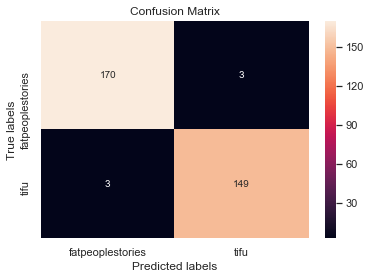

In [54]:
# Using heatmap to plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="g"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['fatpeoplestories', 'tifu']); ax.yaxis.set_ticklabels(['fatpeoplestories', 'tifu']);

In [44]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 544.1505010128021 seconds ---


#### Conclusion
- Logistic Regression is the better model between Multinomial Naive Bayes and Logistic Regression
- Log Reg of 98% recall showed very small False Negatives (E.g. Falsely prediction of "fps" when its "tifu"

### Looking Forward
- Project only utilises two models, more classification models can be easily implemented with GridSearchCV
- If there is heavy class imbalance, rebalancing would be needed  

> **Jupyter slideshow:** This notebook can be displayed as slides. To view it as a slideshow in your browser, type the following in the console:


> `> jupyter nbconvert [this_notebook.ipynb] --to slides --post serve`


> To toggle off the slideshow cell formatting, click the `CellToolbar` button, then `View --> Cell Toolbar --> None`.